In [259]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
import sys, os
sys.path.append('../../src/')
# import toolbox
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from toolbox import *
import pickle
# from toolbox import *

In [260]:
spotCoin = 'eth'
data_name = '%sUSD_BTCUSD_25SEP20'%spotCoin.upper()
OHR_path = 'best_h/%s/'%data_name
data_path = '/Volumes/external_SSD/copulaData/Deribit_ready2/%s/'%data_name
HEs = pd.read_csv('%s_HEs.csv'%spotCoin, index_col=0)
rh_results_df = pd.read_csv('%s_rh_results.csv'%spotCoin, index_col=0)

In [261]:
ERM = lambda x: ERM_estimate_trapezoidal(10, x)
ES1 = lambda x: ES(0.01, x)
ES5 = lambda x: ES(0.05, x)
VaR1 = lambda x: VaR(0.01, x)
VaR5 = lambda x: VaR(0.05, x)
Variance = lambda x: np.var(x)

risk_measures_fn = [Variance, ES5, ES1, VaR5, VaR1, ERM]
risk_measures_dict = dict(zip(risk_measures_name, risk_measures_fn))

In [262]:
rh_copula_selection = rh_results_df.loc[rh_results_df.AIC_selected == 1,:]
rh_copula_selection.loc[:,'datetime'] = pd.to_datetime(rh_copula_selection.loc[:,'datetime'])
# risk_measures_name = list(set(rh_copula_selection.risk_measure))

risk_measures_name = ['Variance', 'ES q=0.05', 'ES q=0.01', 
                      'VaR q=0.05', 'VaR q=0.01', 'ERM k=10']

rh_copula_selection = rh_copula_selection.sort_values('datetime').reset_index(drop=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [263]:
# Stationary Block Bootstrap 2.7.2 of Lahiri
def SB(X, p, T, seed, return_id=True):
    np.random.seed(seed)
    # X: time series to be sampled
    # p: param of Geometric distribution; 1/p = mean of block sample length
    # T: length of pseudo time series 
    X = X.reset_index(drop=True)
    blockL = 0
    s = []
    while blockL < T:
        I = int(np.random.choice(len(X), 1, replace=True))
        L = int(np.random.geometric(p=p, size=1))
        _id = np.linspace(I, I+L-1, num=L)
        _id = list((_id % len(X)).astype(int))
        blockL += len(_id)
        if return_id:
            s+=[_id]
        else:
            s.append(X.loc[_id, :])
    
    if return_id:
        return np.concatenate(s).astype('int')[:T]
    else:
        return pd.concat(s).iloc[:T]

In [264]:
T = len(pd.read_csv(data_path+'train/1.csv', index_col=0)) # = 336
p = 1/4

In [265]:
_id = rh_results_df.risk_measure == risk_measures_name[0]
_id &= rh_results_df.copula == 'Gaussian'
X = rh_results_df.loc[_id].reset_index(drop=True)
sample_id = dict()

N_samples = 500
for seed in range(0,N_samples):
    sample_id[seed] = SB(X,p,T,seed,True)
    

In [266]:
copula_arr = list(set(rh_results_df.copula))

In [267]:
copula_arr

['t_Copula',
 'Gaussian',
 'Frank',
 'Clayton',
 'Plackett',
 'rotGumbel',
 'Gumbel',
 'NIG',
 'Gauss Mix Indep']

In [268]:
HE_results_outer = dict()
for rm in risk_measures_name:
    HE_results = dict()
    for c in copula_arr:
        _id = rh_results_df.risk_measure == rm   
        _id &= rh_results_df.copula == c
        X = rh_results_df.loc[_id,:].copy().reset_index(drop=True)
        fn = risk_measures_dict[rm]
        HE_arr = []
        for seed in list(sample_id.keys()):
            _id = sample_id[seed]
            _df = X.loc[_id, ['rh','rs']]
            HE = 1-(fn(_df.rh)/fn(_df.rs))
            HE_arr.append(HE)
        HE_results[c] = HE_arr
    HE_results_outer[rm] = HE_results

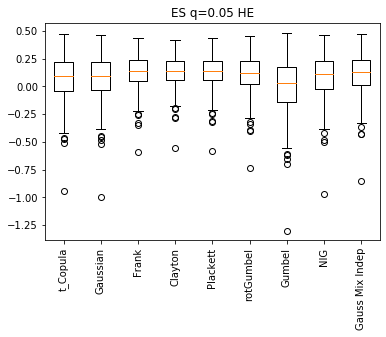

In [269]:
rm = 'ES q=0.05'
toPlot = []
for c in copula_arr:
    toPlot += [HE_results_outer[rm][c]]
    
plt.boxplot(toPlot)
plt.xticks(range(1,len(copula_arr)+1), copula_arr, rotation=90)
plt.title('%s HE'%rm)
plt.show()

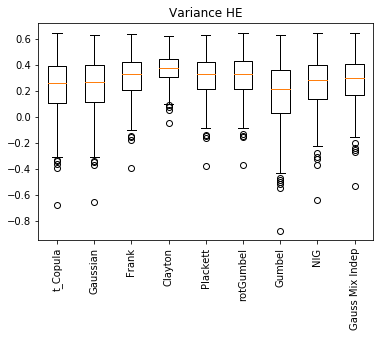

In [270]:
rm = 'Variance'
toPlot = []
for c in copula_arr:
    toPlot += [HE_results_outer[rm][c]]
    
plt.boxplot(toPlot)
plt.xticks(range(1,len(copula_arr)+1), copula_arr, rotation=90)
plt.title('%s HE'%rm)
plt.show()

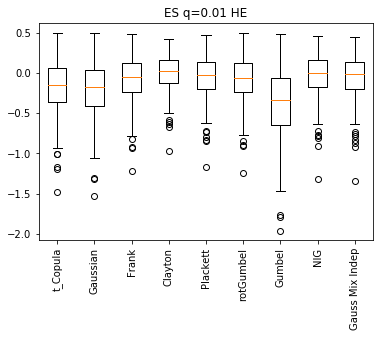

In [271]:
rm = 'ES q=0.01'
toPlot = []
for c in copula_arr:
    toPlot += [HE_results_outer[rm][c]]
plt.boxplot(toPlot)
plt.xticks(range(1,len(copula_arr)+1), copula_arr, rotation=90)
plt.title('%s HE'%rm)
plt.show()

## copula selection

In [206]:
_id = rh_copula_selection.risk_measure == risk_measures_name[0]
X = rh_copula_selection.loc[_id].reset_index(drop=True)

sample_id = dict()

N_samples = 500
for seed in range(0,N_samples):
    sample_id[seed] = SB(X,p,T,seed,True)

In [207]:
HE_results = dict()

for rm in risk_measures_name:
    _id = rh_copula_selection.risk_measure == rm   
    X = rh_copula_selection.loc[_id,:].copy().reset_index(drop=True)
    fn = risk_measures_dict[rm]
    
    HE_arr = []
    for seed in list(sample_id.keys()):
        _id = sample_id[seed]
        _df = X.loc[_id, ['rh','rs']]
        HE = 1-(fn(_df.rh)/fn(_df.rs))
        HE_arr.append(HE)
        
    HE_results[rm] = HE_arr

In [208]:
rm_results = dict()

for rm in risk_measures_name:
    _id = rh_copula_selection.risk_measure == rm   
    X = rh_copula_selection.loc[_id,:].copy().reset_index(drop=True)
    fn = risk_measures_dict[rm]
    
    rm_arr = []
    for seed in list(sample_id.keys()):
        _id = sample_id[seed]
        _df = X.loc[_id, ['rh','rs','copula']]
        rm_arr.append((fn(_df.rh), fn(_df.rs), _df.copula))
        
    rm_results[rm] = rm_arr

In [209]:
_id  = rh_results_df.copula == 'NIG'
_id &= rh_results_df.risk_measure == 'VaR q=0.05'
_df = rh_results_df.loc[_id,:]
1 - VaR5(_df.rh)/VaR5(_df.rs)

0.24284445872196814

In [210]:
_id  = rh_results_df.copula == 'NIG'
_id &= rh_results_df.risk_measure == 'VaR q=0.01'
_df = rh_results_df.loc[_id,:]
1 - VaR1(_df.rh)/VaR1(_df.rs)

0.10999377641437891

In [211]:
_id  = rh_results_df.copula == 'Gaussian'
_id &= rh_results_df.risk_measure == 'VaR q=0.05'
_df = rh_results_df.loc[_id,:]
1 - VaR5(_df.rh)/VaR5(_df.rs)

0.27296152057941236

In [212]:
_id  = rh_results_df.copula == 'Gaussian'
_id &= rh_results_df.risk_measure == 'VaR q=0.01'
_df = rh_results_df.loc[_id,:]
1 - VaR1(_df.rh)/VaR1(_df.rs)

0.08568701192175554

In [213]:
with open('%s_HE_SB_results.pickle'%spotCoin, 'wb') as f:
    pickle.dump(HE_results, f)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc734ac34d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc734ac3f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc734ada7d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc734555990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc734555e90>,
 'means': []}

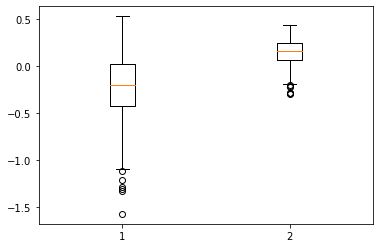

In [214]:
plt.boxplot([HE_results['ES q=0.05'], HE_results['ES q=0.01']])

In [116]:
HEs = []
for seed in list(sample_id.keys()):
    HEs.append(1 - ES5(X.loc[sample_id[seed], 'rh'])/ES5(X.loc[sample_id[seed], 'rs']))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc73339b510>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc73339bf50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc733396850>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc7333a29d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc7333a2ed0>],
 'means': []}

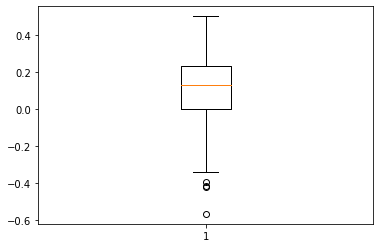

In [117]:
plt.boxplot(HEs)